In [4]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [5]:
import tensorflow as tf
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [11]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class')).reshape(-1, 1)
bool_train_labels = train_labels[:, 0] != 0
val_labels = np.array(val_df.pop('Class')).reshape(-1, 1)
test_labels = np.array(test_df.pop('Class')).reshape(-1, 1)

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model
EPOCHS = 100
BATCH_SIZE = 2048

def early_stopping():
 return tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

neg, pos = np.bincount(raw_df['Class'])
initial_bias = np.log([pos/neg])
initial_bias




model = make_model(output_bias=initial_bias)

untrained_train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
untrained_test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)



baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels))

/home/dan/anaconda3/envs/networks/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - Brier score: 0.0018 - accuracy: 0.9981 - auc: 0.8603 - cross entropy: 0.0124 - fn: 106.7582 - fp: 55.4835 - loss: 0.0124 - prc: 0.3182 - precision: 0.4476 - recall: 0.3383 - tn: 93926.0859 - tp: 52.2418 - val_Brier score: 8.1859e-04 - val_accuracy: 0.9990 - val_auc: 0.9477 - val_cross entropy: 0.0059 - val_fn: 39.0000 - val_fp: 7.0000 - val_loss: 0.0059 - val_prc: 0.7660 - val_precision: 0.8814 - val_recall: 0.5714 - val_tn: 45471.0000 - val_tp: 52.0000
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Brier score: 0.0011 - accuracy: 0.9988 - auc: 0.8695 - cross entropy: 0.0081 - fn: 90.2637 - fp: 13.5604 - loss: 0.0081 - prc: 0.4602 - precision: 0.8018 - recall: 0.4001 - tn: 93970.3047 - tp: 66.4396 - val_Brier score: 7.4868e-04 - val_accuracy: 0.9991 - val_auc: 0.9496 - val_cross entropy: 0.0050 - val_fn: 35.0000 - val_fp: 7.0000 - val_loss: 0.0050 - 

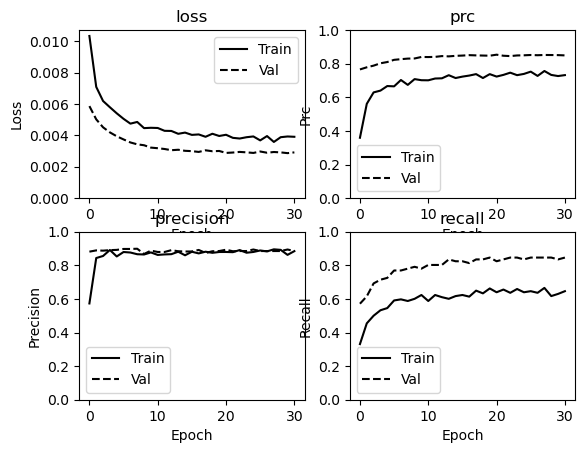

In [17]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color='black', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='black', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    # elif metric == 'auc':
    #   plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    plt.title(metric)

    plt.legend()
plot_metrics(baseline_history)


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


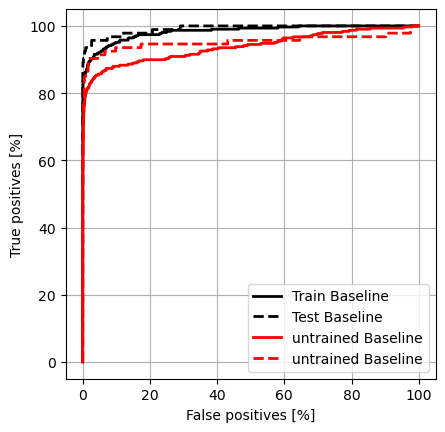

In [12]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
#   plt.xlim([-0.5,20])
#   plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

plot_roc("Train Baseline", train_labels, train_predictions_baseline, color='black')
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color='black', linestyle='--')

plot_roc("untrained Baseline", train_labels, untrained_train_predictions_baseline, color='r')
plot_roc("untrained Baseline", test_labels, untrained_test_predictions_baseline, color='r', linestyle='--')

plt.legend(loc='lower right');


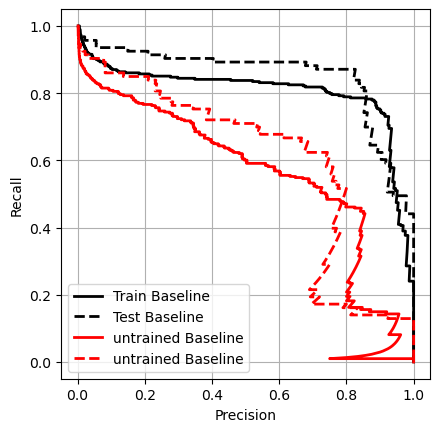

In [14]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Train Baseline", train_labels, train_predictions_baseline, color='black')
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color='black', linestyle='--')

plot_prc("untrained Baseline", train_labels, untrained_train_predictions_baseline, color='r')
plot_prc("untrained Baseline", test_labels, untrained_test_predictions_baseline, color='r', linestyle='--')
plt.legend(loc='lower left');
